In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sqlalchemy
# Connect to database
PWD='root'
USR='root'
SQLALCHEMY_DATABASE_URI = 'mysql+pymysql://{}:{}@localhost:3306/gdb0041'.format(USR, PWD)
engine = sqlalchemy.create_engine(SQLALCHEMY_DATABASE_URI)

**P&L Statement**<br />
Gross = 50<br />
pre-Invoice deduction = 5(for regular customer)<br />
Net-Invoice-sales = 45<br />
post-Invoice deduction = 5(display priority fee)<br />
Net-Sales = 40<br />
COGS = 20 (COST OF GOODS SOLD)<br />
Margin = 20<br />
margin % = 50 (M/NS)<br />

Find the croma customer aggregated by product in monthly basis

In [3]:
query = """
select * from dim_customer 
"""
df_dim_customer = pd.read_sql(query,engine)
#df_dim_customer['customer'].unique()
df_dim_customer[df_dim_customer['customer'] == 'Croma']

,customer_code,customer,platform,channel,market,sub_zone,region
48,90002002,Croma,Brick & Mortar,Retailer,India,India,APAC


To create a fiscal year calendar, add 4 months to the calendar date in the database where September marks the fiscal year's start

In [7]:
query = """
select *,
(CASE when Month(date) in (9,10,11) Then 'Q1'
     when Month(date) in (12,1,2) Then 'Q2'
     when Month(date) in (3,4,5) Then 'Q3' else 'Q4' END ) AS Quater
 from fact_sales_monthly
where customer_code = 90002002 and
year(date_add(date,interval 4 month)) = 2021 and
(CASE when Month(date) in (9,10,11) Then 'Q1'
     when Month(date) in (12,1,2) Then 'Q2'
     when Month(date) in (3,4,5) Then 'Q3' else 'Q4' END )='Q1'
"""
df_fact_sales_monthly = pd.read_sql(query,engine)
print(df_fact_sales_monthly.tail())
print(df_fact_sales_monthly['date'].unique())

           date product_code  customer_code  sold_quantity Quater
663  2020-10-01  A7321160301       90002002            479     Q1
664  2020-09-01  A7321160302       90002002            507     Q1
665  2020-10-01  A7321160302       90002002            243     Q1
666  2020-09-01  A7321160303       90002002            190     Q1
667  2020-10-01  A7321160303       90002002            586     Q1
['Q1']
[datetime.date(2020, 9, 1) datetime.date(2020, 10, 1)]


<Axes: ylabel='date'>

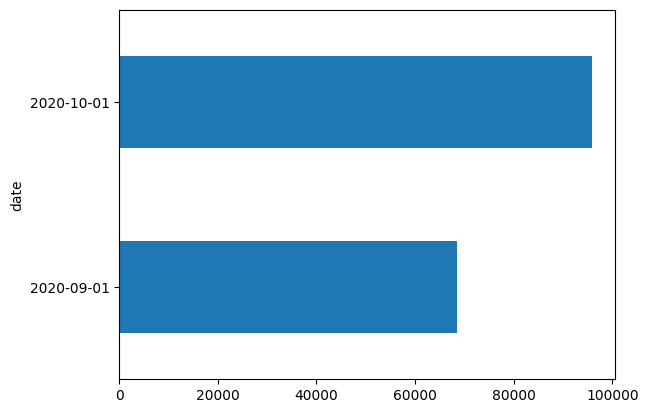

In [12]:
g = df_fact_sales_monthly.groupby('date')['sold_quantity'].sum()
print(g)
g.plot(kind='barh')

product_code
A6818160202    3111
A6819160203    3039
A6818160201    2525
A6720160103    2450
A6419160303    2302
Name: sold_quantity, dtype: int64


<Axes: ylabel='product_code'>

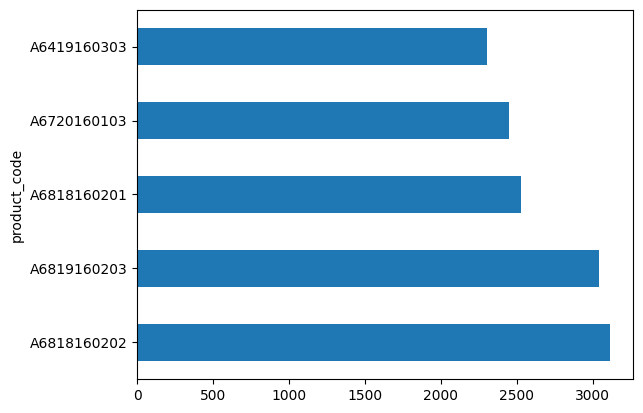

In [20]:
g = df_fact_sales_monthly.groupby('product_code')['sold_quantity'].sum()
print(g.sort_values(ascending=False).nlargest(5))
g.sort_values(ascending=True).nlargest(5).plot(kind='barh')

In [21]:
query = """
select m.date,m.product_code,
       p.product,p.variant,m.sold_quantity,
       gp.gross_price,round(m.sold_quantity*gp.gross_price,2) as Total_gp
 from fact_sales_monthly m
 join dim_product p on p.product_code = m.product_code
 join fact_gross_price gp on gp.product_code = m.product_code and gp.fiscal_year = get_fiscal_year(m.date)
where customer_code = 90002002 and
get_fiscal_year(date) = 2021;
"""
fact_sales_monthly = pd.read_sql(query,engine)
print(fact_sales_monthly.tail())

            date product_code          product  variant  sold_quantity  \
3001  2021-02-01  A7321160303  AQ Wi Power Dx3  Premium            186   
3002  2021-04-01  A7321160303  AQ Wi Power Dx3  Premium            148   
3003  2021-05-01  A7321160303  AQ Wi Power Dx3  Premium            487   
3004  2021-06-01  A7321160303  AQ Wi Power Dx3  Premium            289   
3005  2021-08-01  A7321160303  AQ Wi Power Dx3  Premium            158   

      gross_price  Total_gp  
3001      42.8483   7969.78  
3002      42.8483   6341.55  
3003      42.8483  20867.12  
3004      42.8483  12383.16  
3005      42.8483   6770.03  


product
AQ BZ Allin1    925596.80
AQ Qwerty       760927.47
AQ Trigger      691435.12
AQ Gen X        625218.37
AQ Gen Y        616265.01
Name: Total_gp, dtype: float64


<Axes: xlabel='product'>

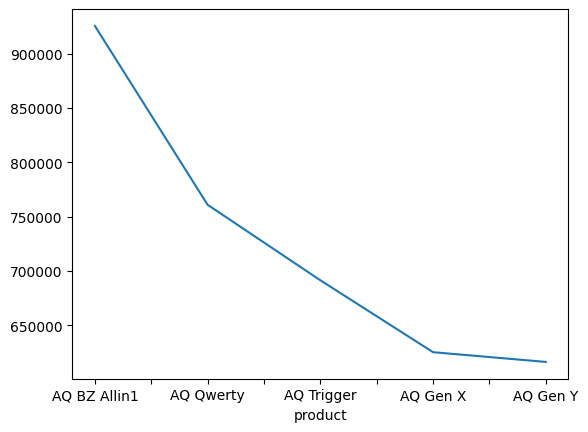

In [26]:
g = fact_sales_monthly.groupby('product')['Total_gp'].sum()
print(g.nlargest(5))
g.nlargest(5).plot()

variant
Standard    2297215.39
Premium     2149772.85
Plus        1995730.07
Plus 2      1784269.76
Plus 1      1542003.79
Name: Total_gp, dtype: float64


<Axes: ylabel='variant'>

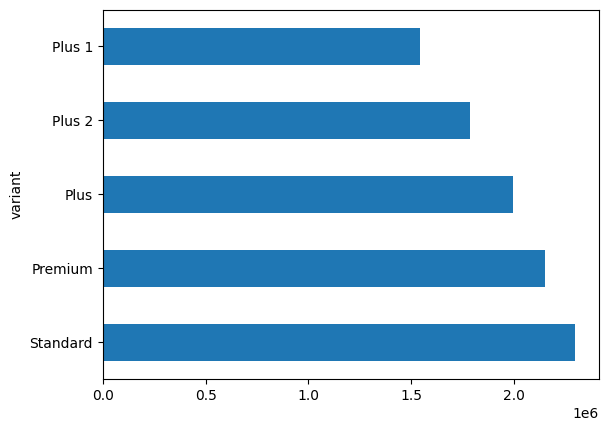

In [37]:
g = fact_sales_monthly.groupby('variant')['Total_gp'].sum()
print(g.nlargest())
g.nlargest().plot(kind='barh')

Croma month wise Total Sales Amount

In [38]:
query = """
select m.date,
       sum(round(m.sold_quantity*gp.gross_price,2)) as Total_gp
 from fact_sales_monthly m
 join fact_gross_price gp on gp.product_code = m.product_code and gp.fiscal_year = get_fiscal_year(m.date)
where customer_code = 90002002 
group by m.date
order by m.date desc;
"""
fact_sales_monthly = pd.read_sql(query,engine)
print(fact_sales_monthly.tail())

          date   Total_gp
34  2018-02-01  144799.54
35  2018-01-01  127574.73
36  2017-12-01  245673.84
37  2017-10-01  162687.56
38  2017-09-01  122407.57


In [41]:
g = fact_sales_monthly.groupby('date')['Total_gp'].sum()
g.nlargest(n=5)

date
2021-12-01    19537146.58
2021-10-01    13908229.35
2021-09-01    11192823.18
2020-12-01     4078790.04
2020-10-01     3109316.96
Name: Total_gp, dtype: float64

In [43]:
query = """
with cte_pre_invoice as
(
select m.date,Year(adddate(m.date,interval 4 month)) as fiscal_year,
		m.product_code,m.sold_quantity, p.product,p.variant,c.market, gp.gross_price,
        round(m.sold_quantity*gp.gross_price,2) as Total_gp,pd.pre_invoice_discount_pct
from fact_sales_monthly m 
 join dim_product p on p.product_code = m.product_code
 join dim_customer c on c.customer_code = m.customer_code
 join fact_gross_price gp on gp.product_code = m.product_code and gp.fiscal_year = get_fiscal_year(m.date)
 join fact_pre_invoice_deductions pd on pd.customer_code = m.customer_code and pd.fiscal_year = get_fiscal_year(m.date)
where m.customer_code in (90002002,90020102,70019204)
)select *,
round((1-pre_invoice_discount_pct)*Total_gp,2) as Net_Invoice_Sales 
from  cte_pre_invoice;
"""
top_customer = pd.read_sql(query,engine)
print(top_customer.tail())

             date  fiscal_year product_code  sold_quantity          product  \
17641  2021-10-01         2022  A7321160303             15  AQ Wi Power Dx3   
17642  2021-11-01         2022  A7321160303              6  AQ Wi Power Dx3   
17643  2021-12-01         2022  A7321160303             45  AQ Wi Power Dx3   
17644  2021-12-01         2022  A7321160303            523  AQ Wi Power Dx3   
17645  2021-12-01         2022  A7321160303             26  AQ Wi Power Dx3   

       variant   market  gross_price  Total_gp  pre_invoice_discount_pct  \
17641  Premium  Austria      43.5559    653.34                    0.3011   
17642  Premium   Sweden      43.5559    261.34                    0.2581   
17643  Premium   Sweden      43.5559   1960.02                    0.2581   
17644  Premium    India      43.5559  22779.74                    0.1828   
17645  Premium  Austria      43.5559   1132.45                    0.3011   

       Net_Invoice_Sales  
17641             456.62  
17642         

In [45]:
g = top_customer.groupby('market')['Total_gp'].sum()
g.nlargest()

market
India      79236070.63
Sweden      3107419.17
Austria     2758811.14
Name: Total_gp, dtype: float64

In [46]:
g = top_customer.groupby('variant')['Net_Invoice_Sales'].sum().sort_values(ascending=False)
g.nlargest()

variant
Standard    6664291.20
Premium     6431053.49
Plus        4813446.66
Plus 2      4494504.81
Plus 1      3796930.97
Name: Net_Invoice_Sales, dtype: float64

In [47]:
query = """
select *,
((1- Incude_other_postdeduction)*Net_Invoice_Sales) as Net_sale
from net_sales_vw
where customer_code in (90002002,90020102,70019204);
"""
top_customer = pd.read_sql(query,engine)
print(top_customer.head())

         date  fiscal_year product_code  customer_code  sold_quantity  \
0  2017-09-01         2018  A0118150101       90002002             40   
1  2017-09-01         2018  A0118150101       90002002             40   
2  2017-09-01         2018  A0118150101       90002002             40   
3  2017-09-01         2018  A0118150101       90002002             40   
4  2017-09-01         2018  A0118150101       90002002             40   

                                             product   variant customer  \
0  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...  Standard    Croma   
1  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...  Standard    Croma   
2  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...  Standard    Croma   
3  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...  Standard    Croma   
4  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...  Standard    Croma   

  market   channel region  gross_price  Total_gp  pre_invoice_discount_pct  \
0  India  Retailer   APAC      1

In [48]:
top_customer['Net_sale_mln'] = top_customer['Net_sale'].apply(lambda x: x/1000000)
top_customer.tail(1)

,date,fiscal_year,product_code,customer_code,sold_quantity,product,variant,customer,market,channel,region,gross_price,Total_gp,pre_invoice_discount_pct,Net_Invoice_Sales,Incude_other_postdeduction,Net_sale,Net_sale_mln
517028,2021-12-01,2022,A7321160303,90020102,26,AQ Wi Power Dx3,Premium,Fnac-Darty,Austria,Retailer,EU,43.5559,1132.45,0.3011,791.47,0.3724,496.726572,0.000497


<Axes: ylabel='customer'>

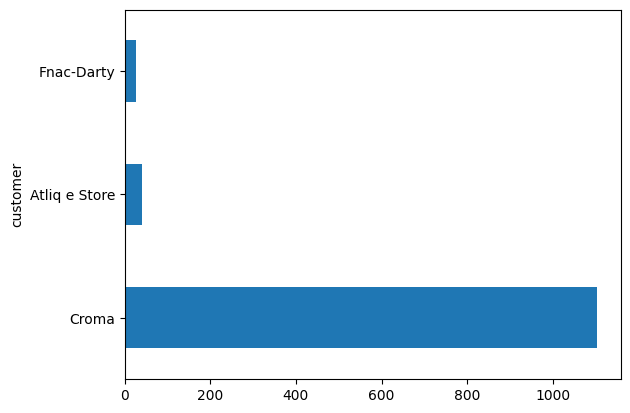

In [113]:
g = top_customer.groupby('customer',sort=False)['Net_sale_mln'].sum()
#print(g.sort_values().nlargest())
g.plot(kind='barh')

<Axes: ylabel='market'>

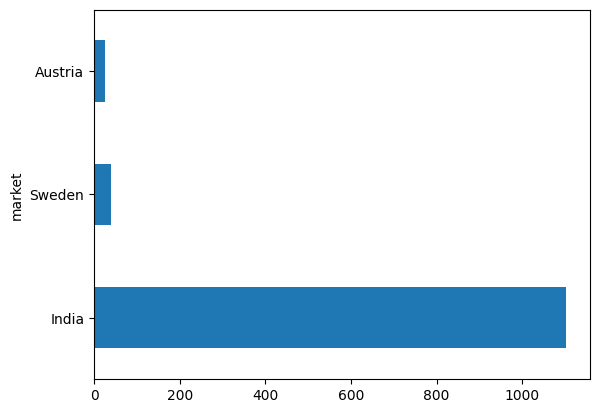

In [108]:
g = top_customer.groupby('market',sort=False)['Net_sale_mln'].sum()
#print(g.nlargest())
g.plot(kind='barh')

channel
Direct        40
Retailer    1130
Name: Net_sale_mln, dtype: int64
['Direct - 40', 'Retailer - 1130']
[39.874997715714, 1130.093074212043]


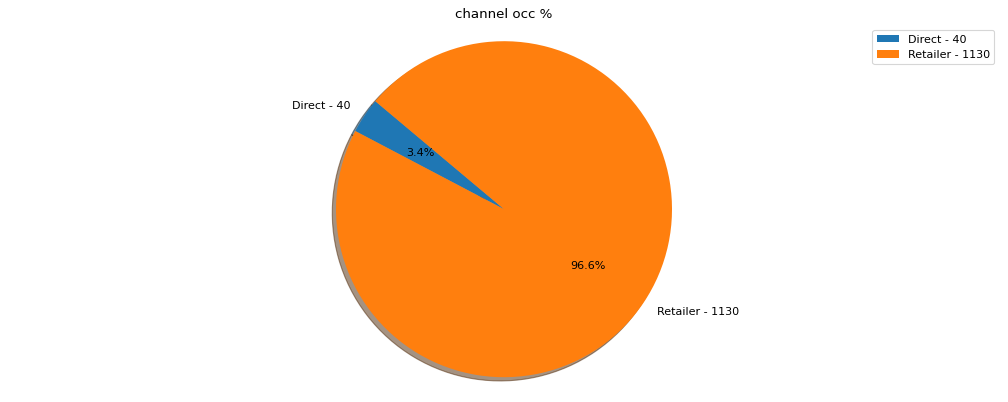

In [105]:
g = top_customer.groupby('channel',sort=True)['Net_sale_mln'].sum()
print(g.round().astype('int64'))

names = []
values = []
for name in g.index:
    names.append(f"{name} - {g.loc[name].round().astype('int')}")
    values.append(g.loc[name])

print(names)
print(values)

plt.figure(figsize=(16, 6), dpi=80)
plt.pie(values,labels=names,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('channel occ %')

plt.legend()
plt.show()


In [27]:
top_customer.groupby('region')['Net_sale_mln'].sum()

region
APAC    1103.459823
EU        66.508249
Name: Net_sale_mln, dtype: float64